<a href="https://colab.research.google.com/github/jaydent22/661-final-project/blob/main/gpt-neo/661_GPT_Neo_SST2_CoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-Neo SST-2 Chain of Thought

This notebook will use zero-shot chain-of-thought prompting on a pretrained GPT-Neo model to measure its performance on the Stanford Sentiment Treebank dataset. Performance of human-generated and ChatGPT-generated prompts will be compared.

## Setup

In [ ]:
!pip install transformers datasets pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from transformers import GPT2TokenizerFast, GPTNeoForCausalLM
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from time import time
import random

In [ ]:
cuda = torch.device('cuda')

In [ ]:
model_id = "EleutherAI/gpt-neo-2.7B"

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

In [ ]:
model = GPTNeoForCausalLM.from_pretrained(model_id)
model.to(cuda)
model.eval()
print(model)

model.safetensors:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2560)
    (wpe): Embedding(2048, 2560)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-31): 32 x GPTNeoBlock(
        (ln_1): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (v_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (q_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (out_proj): Linear(in_features=2560, out_features=2560, bias=True)
          )
        )
        (ln_2): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2560, out_features=10240, bias=True)
          (c_proj)

In [ ]:
def predict_sentiment(text):
  inputs = tokenizer(wrap_sentence(text), truncation=True, return_tensors="pt").to(cuda)
  output = model.generate(
      **inputs,
      max_new_tokens=80,
      num_return_sequences=1,
      pad_token_id=tokenizer.eos_token_id,
      # no_repeat_ngram_size=2,
      # repetition_penalty=1.7,
      # do_sample=True,
      # temperature=0.2,
      # top_k=50,
      # top_p=0.9,
  )
  return tokenizer.decode(output[0], skip_special_tokens=True)

## Dataset

In [ ]:
dataset = load_dataset("sst2")
print(type(dataset))

README.md:   0%|          | 0.00/5.27k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

<class 'datasets.dataset_dict.DatasetDict'>


In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})


In [ ]:
# baseline SST-2 models used validation dataset for inference
for i, val in enumerate(dataset['validation']):
    print(val)
    if i == 10:
        break

{'idx': 0, 'sentence': "it 's a charming and often affecting journey . ", 'label': 1}
{'idx': 1, 'sentence': 'unflinchingly bleak and desperate ', 'label': 0}
{'idx': 2, 'sentence': 'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . ', 'label': 1}
{'idx': 3, 'sentence': "the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . ", 'label': 1}
{'idx': 4, 'sentence': "it 's slow -- very , very slow . ", 'label': 0}
{'idx': 5, 'sentence': 'although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . ', 'label': 1}
{'idx': 6, 'sentence': 'a sometimes tedious film . ', 'label': 0}
{'idx': 7, 'sentence': "or doing last year 's taxes with your ex-wife . ", 'label': 0}
{'idx': 8, 'sentence': "you do n't have to know about music to appreciate the film 's easygoing blend of comedy and romance . ", 'label': 1}
{'idx': 9, 'sentence':

## Generate CoT Examples From Training Set

This section will extract three high-quality (i.e., correct and coherent) classification examples from the training set. These examples will be used to perform auto-CoT on the model for performance on the validation set.

In [ ]:
examples = []

In [ ]:
example_sentences = []

In [ ]:
def wrap_sentence(text):
  return f"""
Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review.
Finally, state the sentiment as either 'positive' or 'negative'. Do not state any sentiment other than 'positive' or 'negative'.
Review: This movie is really good
Reasoning:
Let's think step by step. The word "good" is positive. Therefore, the review expresses a positive sentiment.
Sentiment: positive

Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review.
Finally, state the sentiment as either 'positive' or 'negative'. Do not state any sentiment other than 'positive' or 'negative'.
Review: This movie sucks
Reasoning:
Let's think step by step. The word "sucks" is negative. Therefore, the review expresses a negative sentiment.
Sentiment: negative

Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review.
Finally, state the sentiment as either 'positive' or 'negative'. Do not state any sentiment other than 'positive' or 'negative'.
Review: the acting was fine, but the writing ruined it
Reasoning:
Let's think step by step. The word "fine" is positive, but it's followed by the negative word "ruined". Therefore, the overall review expresses a negative sentiment.
Sentiment: negative

Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review.
Finally, state the sentiment as either 'positive' or 'negative'. Do not state any sentiment other than 'positive' or 'negative'.
Review: {text}
Reasoning:
Let's think step by step.
"""

In [ ]:
sentences = dataset['train']['sentence']
labels = dataset['train']['label']

In [ ]:
reasonings = []
start = 6
for sentence in sentences[start*5:5*(start+1)]:
  sentiment = predict_sentiment(sentence)
  print(sentiment)
  print("------------------------------------------------")
  reasonings.append(sentiment.split("Review: ")[-1])


Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review.
Finally, state the sentiment as either 'positive' or 'negative'. Do not state any sentiment other than 'positive' or 'negative'.
Review: This movie is really good
Reasoning:
Let's think step by step. The word "good" is positive. Therefore, the review expresses a positive sentiment.
Sentiment: positive

Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review.
Finally, state the sentiment as either 'positive' or 'negative'. Do not state any sentiment other than 'positive' or 'negative'.
Review: This movie sucks
Reasoning:
Let's think step by step. The word "sucks" is negative. Therefore, the review expresses a negative sentiment.
Sentiment: negative

Classify the following review as positive or negative
First, identi

In [ ]:
for i in range(len(reasonings)):
  print("Sentence: " + reasonings[i])
  # print(reasonings[i])
  print(f"True label: {'negative' if labels[i] == 0 else 'positive'}")
  print("------------------------------------------------")

Sentence: the action is stilted 
Reasoning:
Let's think step by step.
The word “action” is both positive (“stilting’) and neutral (not ‘stilled  ), therefore, it expresses no sentiment at all. Additionally, there is no word that is more positive than „action", so we can safely conclude that the entire review states a neutral sentiment,
True label: negative
------------------------------------------------
Sentence: on all cylinders 
Reasoning:
Let's think step by step.
The word “on” is followed immediately by another word that is also positive (“cylinders’). Therefore this review suggests a neutral sentiment of ‘on all pistons „‛‹‰‼″‴‵‾›‡‚‬‖�
True label: negative
------------------------------------------------
Sentence: will find little of interest in this film , which is often preachy and poorly acted 
Reasoning:
Let's think step by step.
The word can be positive if you remove the word that follows it. However, if the phrase "often" were added to the sentence, then the meaning would c

In [ ]:
example_reviews.append(reasonings[-1])
example_reviews

["redundant concept \nReasoning:\nLet's think step by step.\nThe word “redundant” is not positive at all. It's negative because it has two negative meanings. So, we can say that the sentence expresses an overall negative feeling.",
 "cold movie \nReasoning:\nLet's think step by step.\nThe word “cold” is not positive at all. It's just a neutral word. Hence, we can classify the entire review into a non-positive category. (See above)\nSo, based on the above, this review is classified as negative with a score of -1.5.",
 "a smile on your face\nReasoning:\nLet's think step by step.\nThe word “smile” is definitely positive because it follows the word that is considered positive by dictionary.com. So, this review will express a strong positive feeling.",
 "enriched by an imaginatively mixed cast of antic spirits \nReasoning:\nLet's think step by step.\nThe word “enriched” is a very positive word. But it is followed with the word which is very negative, ‘antic’. So the whole review express a h

In [ ]:
print(example_sentences[0]+"\nReasoning:"+examples[0])

redundant concept 
Reasoning:
Let's think step by step.
The word “redundant” is not positive at all. It's negative because it has two negative meanings. So, we can say that the sentence expresses an overall negative feeling.


In [ ]:
example_reviews = []
for ex, sent in zip(examples, example_sentences):
  example_reviews.append(sent+"\nReasoning:"+ex)

["redundant concept \nReasoning:\nLet's think step by step.\nThe word “redundant” is not positive at all. It's negative because it has two negative meanings. So, we can say that the sentence expresses an overall negative feeling.",
 "cold movie \nReasoning:\nLet's think step by step.\nThe word “cold” is not positive at all. It's just a neutral word. Hence, we can classify the entire review into a non-positive category. (See above)\nSo, based on the above, this review is classified as negative with a score of -1.5.",
 "a smile on your face\nReasoning:\nLet's think step by step.\nThe word “smile” is definitely positive because it follows the word that is considered positive by dictionary.com. So, this review will express a strong positive feeling."]

In [ ]:
for rev in example_reviews:
  print("Review: " + rev)
  print("---------------------------------------")

Review: redundant concept 
Reasoning:
Let's think step by step.
The word “redundant” is not positive at all. It's negative because it has two negative meanings. So, we can say that the sentence expresses an overall negative feeling.
---------------------------------------
Review: cold movie 
Reasoning:
Let's think step by step.
The word “cold” is not positive at all. It's just a neutral word. Hence, we can classify the entire review into a non-positive category. (See above)
So, based on the above, this review is classified as negative with a score of -1.5.
---------------------------------------
Review: a smile on your face
Reasoning:
Let's think step by step.
The word “smile” is definitely positive because it follows the word that is considered positive by dictionary.com. So, this review will express a strong positive feeling.
---------------------------------------
Review: enriched by an imaginatively mixed cast of antic spirits 
Reasoning:
Let's think step by step.
The word “enriche

After processing, the reviews used for chain of thought prompting are as follows:

<hr>

Review: lend some dignity to a dumb story

Reasoning:

Let's think step by step.
The word “dignity” is a neutral word. It doesn't have any positive connotation. So, it doesn't express a strong positive feeling. However, when we add the word that follows it, "dumb", then it becomes a negative feeling word. Therefore, the sentence expresses a negative sentiment

<hr>

Review: on the worst revenge-of-the-nerds clichés the filmmakers could dredge up

Reasoning:

Let's think step by step.
The word “worst” is a negative adjective. It's not followed with any positive words, so the entire sentence is expressing a negative sentiment.

<hr>

Review: a smile on your face

Reasoning:
Let's think step by step.
The word “smile” is definitely positive, so this review expresses a positive sentiment.

## Tokenize

In [ ]:
# ChatGPT-generated prompt
prefix = """
Analyze the sentiment of the following sentence.
Determine the overall sentiment expressed in the sentence.
Determine what contributes to that sentiment.
State the sentiment as either 'positive' or 'negative'.
Sentence: """
val_ds = dataset["validation"]
val_ds = val_ds.map(lambda x: {"sentence": prefix + "\n" + x["sentence"] + "\nReasoning: "})

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [ ]:
label_map = {
    0: "negative",
    1: "positive"
}

def map_labels(data):
  data["sentiment"] = label_map[data["label"]]
  return data

val_ds = val_ds.map(map_labels)

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [ ]:
for i, val in enumerate(val_ds):
    print(val)
    if i == 10:
        break

{'idx': 0, 'sentence': "\nAnalyze the sentiment of the following sentence.\nDetermine the overall sentiment expressed in the sentence.\nDetermine what contributes to that sentiment.\nState the sentiment as either 'positive' or 'negative'.\nSentence: \nit 's a charming and often affecting journey . \nReasoning: ", 'label': 1, 'sentiment': 'positive'}
{'idx': 1, 'sentence': "\nAnalyze the sentiment of the following sentence.\nDetermine the overall sentiment expressed in the sentence.\nDetermine what contributes to that sentiment.\nState the sentiment as either 'positive' or 'negative'.\nSentence: \nunflinchingly bleak and desperate \nReasoning: ", 'label': 0, 'sentiment': 'negative'}
{'idx': 2, 'sentence': "\nAnalyze the sentiment of the following sentence.\nDetermine the overall sentiment expressed in the sentence.\nDetermine what contributes to that sentiment.\nState the sentiment as either 'positive' or 'negative'.\nSentence: \nallows us to hope that nolan is poised to embark a major 

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
def tokenize_data(data):
  inputs = tokenizer(
      data["sentence"],
      padding="max_length",
      truncation=True,
      max_length=200,
      return_tensors="pt"
  )
  labels = tokenizer(
      data["sentiment"],
      padding="max_length",
      truncation=True,
      max_length=2,
      return_tensors="pt"
  )
  inputs["label"] = labels["input_ids"]
  return inputs

In [ ]:
tokenized = val_ds.map(tokenize_data, batched=True)

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [ ]:
for i, val in enumerate(tokenized):
    print(val)
    if i == 10:
        break

{'idx': 0, 'sentence': "\nAnalyze the sentiment of the following sentence.\nDetermine the overall sentiment expressed in the sentence.\nDetermine what contributes to that sentiment.\nState the sentiment as either 'positive' or 'negative'.\nSentence: \nit 's a charming and often affecting journey . \nReasoning: ", 'label': [24561, 50256], 'sentiment': 'positive', 'input_ids': [198, 37702, 2736, 262, 15598, 286, 262, 1708, 6827, 13, 198, 35, 2357, 3810, 262, 4045, 15598, 6241, 287, 262, 6827, 13, 198, 35, 2357, 3810, 644, 22625, 284, 326, 15598, 13, 198, 9012, 262, 15598, 355, 2035, 705, 24561, 6, 393, 705, 31591, 4458, 198, 31837, 594, 25, 220, 198, 270, 705, 82, 257, 23332, 290, 1690, 13891, 7002, 764, 220, 198, 45008, 278, 25, 220, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256

In [ ]:
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
batch_size = 32
num_workers = 4
loader = DataLoader(tokenized, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

## Inference

In [ ]:
def wrap_sentence(text):
  return f"""
Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review as positive or negative.
State the sentiment in the form
Sentiment: positive or negative

Review: lend some dignity to a dumb story
Reasoning:
Let's think step by step. The word “dignity” is a neutral word. It doesn't have any positive connotation. So, it doesn't express a strong positive feeling. However, when we add the word that follows it, "dumb", then it becomes a negative feeling word. So, the sentence expresses a negative sentiment
Sentiment: negative

Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review as positive or negative.
State the sentiment in the form
Sentiment: positive or negative

Review: on the worst revenge-of-the-nerds clichés the filmmakers could dredge up
Reasoning:
Let's think step by step. The word “worst” is a negative adjective. It's not followed with any positive words, so the entire sentence is expressing a negative sentiment.
Sentiment: negative

Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review as positive or negative.
State the sentiment in the form
Sentiment: positive or negative

Review: a smile on your face
Reasoning:
Let's think step by step. The word “smile” is definitely positive, so this review expresses a positive sentiment.
Sentiment: positive

Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review as positive or negative.
State the sentiment in the form
Sentiment: positive or negative

Review: {text}
Reasoning:
Let's think step by step.
"""

In [ ]:
text = "I really liked this movie"
print(predict_sentiment(text))


Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review as positive or negative.
State the sentiment in the form
Sentiment: positive or negative

Review: lend some dignity to a dumb story
Reasoning:
Let's think step by step. The word “dignity” is a neutral word. It doesn't have any positive connotation. So, it doesn't express a strong positive feeling. However, when we add the word that follows it, "dumb", then it becomes a negative feeling word. So, the sentence expresses a negative sentiment
Sentiment: negative

Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review as positive or negative.
State the sentiment in the form
Sentiment: positive or negative

Review: on the worst revenge-of-the-nerds clichés the filmmakers could dredge up
Reasoning:
Let's think step by ste

In [ ]:
pred_sents = []
true_sents = []
for i in range(5):
  rand = random.randint(0, len(dataset["validation"]))
  text = dataset["validation"][rand]
  print(text['sentence'])
  sent = 'negative' if text['label'] == 0 else 'positive'
  print(f"True label: {sent}")
  true_sents.append(sent)
  output = predict_sentiment(text['sentence'])
  print(output)
  pred_sents.append(output.split("Sentiment: ")[-1].split("\n")[0])
  print("------------------------------------------------")

mr. tsai is a very original artist in his medium , and what time is it there ? 
True label: positive

Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review as positive or negative.
State the sentiment in the form
Sentiment: positive or negative

Review: lend some dignity to a dumb story
Reasoning:
Let's think step by step. The word “dignity” is a neutral word. It doesn't have any positive connotation. So, it doesn't express a strong positive feeling. However, when we add the word that follows it, "dumb", then it becomes a negative feeling word. So, the sentence expresses a negative sentiment
Sentiment: negative

Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review as positive or negative.
State the sentiment in the form
Sentiment: positive or negative

Review: on the

In [ ]:
print(true_sents)
print(pred_sents)

['positive', 'negative', 'positive', 'negative', 'negative']
['positive', 'negative', 'negative', 'negative', 'negative']


In [ ]:
len(dataset['validation'])

872

In [ ]:
t0 = time()
all_preds = []
all_labels = []
for i in range(len(dataset['validation'])):
  text = dataset["validation"][i]
  sent = 'negative' if text['label'] == 0 else 'positive'
  all_labels.append(sent)
  output = predict_sentiment(text['sentence'])
  all_preds.append(output.split("Sentiment: ")[-1].split("\n")[0])
  if i % 100 == 99:
    print(f"Time taken: {time()-t0: .3f}")
    print(f"Processed {i+1} reviews")
print(f"Time taken: {time()-t0}")

Time taken:  261.507
Processed 100 reviews
Time taken:  522.279
Processed 200 reviews
Time taken:  782.323
Processed 300 reviews
Time taken:  1044.192
Processed 400 reviews
Time taken:  1305.747
Processed 500 reviews
Time taken:  1567.559
Processed 600 reviews
Time taken:  1827.510
Processed 700 reviews
Time taken:  2086.379
Processed 800 reviews
Time taken: 2272.134882926941


In [ ]:
preds = np.array([1 if x == "positive" else 0 for x in all_preds])
labels = np.array([1 if x == "positive" else 0 for x in all_labels])

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.60      0.87      0.71       428
           1       0.78      0.44      0.56       444

    accuracy                           0.65       872
   macro avg       0.69      0.66      0.64       872
weighted avg       0.69      0.65      0.64       872



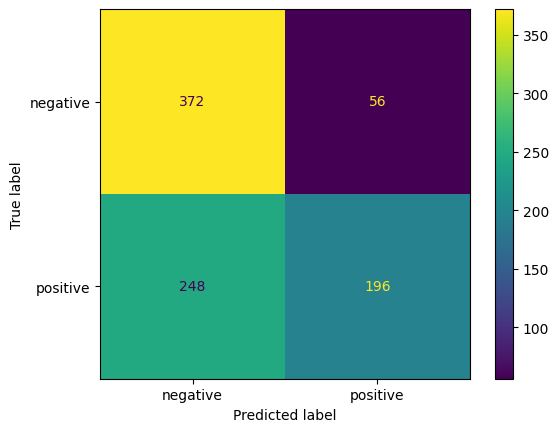

In [ ]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])
disp.plot()
plt.show()

0.6553001599730571


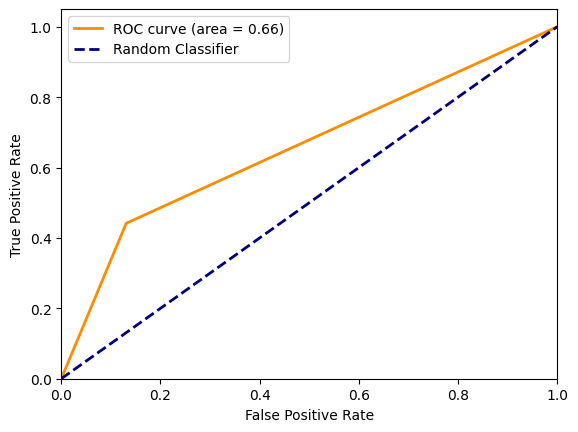

In [ ]:
tpr, fpr, _ = roc_curve(labels, preds)
roc_auc = auc(tpr, fpr)
print(roc_auc)
plt.figure()
plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()

Text(0, 0.5, 'Accuracy (%)')

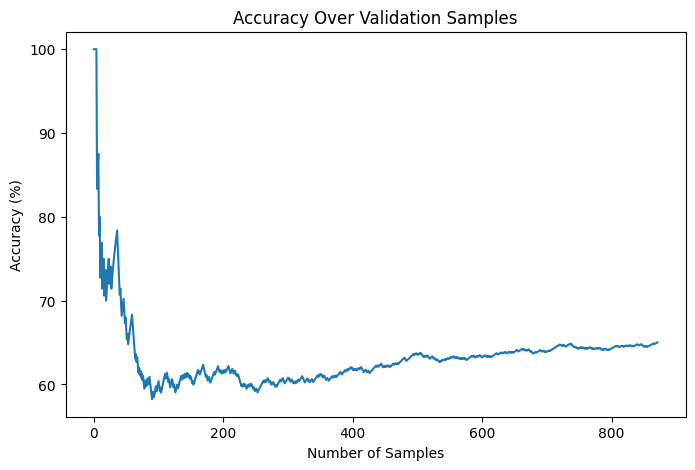

In [ ]:
accuracies = np.cumsum(np.array(all_labels) == np.array(all_preds)) / np.arange(1, len(all_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Validation Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")

### Omitting one example (i.e., have one positive and one negative chain of thought example)

In [54]:
def predict_sentiment(text):
  inputs = tokenizer(wrap_sentence(text), truncation=True, return_tensors="pt").to(cuda)
  output = model.generate(
      **inputs,
      max_new_tokens=70,
      num_return_sequences=1,
      pad_token_id=tokenizer.eos_token_id,
      # no_repeat_ngram_size=2,
      # repetition_penalty=1.7,
      # do_sample=True,
      # temperature=0.2,
      # top_k=50,
      # top_p=0.9,
  )
  return tokenizer.decode(output[0], skip_special_tokens=True)

In [55]:
def wrap_sentence(text):
  return f"""
Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review as positive or negative.
State the sentiment in the form
Sentiment: positive or negative

Review: on the worst revenge-of-the-nerds clichés the filmmakers could dredge up
Reasoning:
Let's think step by step. The word “worst” is a negative adjective. It's not followed with any positive words, so the entire sentence is expressing a negative sentiment.
Sentiment: negative

Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review as positive or negative.
State the sentiment in the form
Sentiment: positive or negative

Review: a smile on your face
Reasoning:
Let's think step by step. The word “smile” is definitely positive, so this review expresses a positive sentiment.
Sentiment: positive

Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review as positive or negative.
State the sentiment in the form
Sentiment: positive or negative

Review: {text}
Reasoning:
Let's think step by step.
"""

In [56]:
text = "I really liked this movie"
print(predict_sentiment(text))


Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review as positive or negative.
State the sentiment in the form
Sentiment: positive or negative

Review: on the worst revenge-of-the-nerds clichés the filmmakers could dredge up
Reasoning:
Let's think step by step. The word “worst” is a negative adjective. It's not followed with any positive words, so the entire sentence is expressing a negative sentiment.
Sentiment: negative

Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review as positive or negative.
State the sentiment in the form
Sentiment: positive or negative

Review: a smile on your face
Reasoning:
Let's think step by step. The word “smile” is definitely positive, so this review expresses a positive sentiment.
Sentiment: positive

Classify the following review a

In [57]:
pred_sents = []
true_sents = []
for i in range(5):
  rand = random.randint(0, len(dataset["validation"]))
  text = dataset["validation"][rand]
  print(text['sentence'])
  sent = 'negative' if text['label'] == 0 else 'positive'
  print(f"True label: {sent}")
  true_sents.append(sent)
  output = predict_sentiment(text['sentence'])
  print(output)
  pred_sents.append(output.split("Sentiment: ")[-1].split("\n")[0])
  print("------------------------------------------------")

nelson 's brutally unsentimental approach ... sucks the humanity from the film , leaving behind an horrific but weirdly unemotional spectacle . 
True label: negative

Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review as positive or negative.
State the sentiment in the form
Sentiment: positive or negative

Review: on the worst revenge-of-the-nerds clichés the filmmakers could dredge up
Reasoning:
Let's think step by step. The word “worst” is a negative adjective. It's not followed with any positive words, so the entire sentence is expressing a negative sentiment.
Sentiment: negative

Classify the following review as positive or negative
First, identify the positive and negative words.
Then, determine the overall sentiment expressed in the review as positive or negative.
State the sentiment in the form
Sentiment: positive or negative

Review: a smile on your face
Reasoning:


In [58]:
print(pred_sents)
print(true_sents)

['negative', 'negative', 'positive', 'positive', 'negative']
['negative', 'positive', 'positive', 'negative', 'negative']


In [59]:
t0 = time()
all_preds = []
all_labels = []
for i in range(len(dataset['validation'])):
  text = dataset["validation"][i]
  sent = 'negative' if text['label'] == 0 else 'positive'
  all_labels.append(sent)
  output = predict_sentiment(text['sentence'])
  all_preds.append(output.split("Sentiment: ")[-1].split("\n")[0])
  if i % 100 == 99:
    print(f"Time taken: {time()-t0: .3f}")
    print(f"Processed {i+1} reviews")
print(f"Time taken: {time()-t0}")

Time taken:  228.998
Processed 100 reviews
Time taken:  456.909
Processed 200 reviews
Time taken:  684.020
Processed 300 reviews
Time taken:  909.417
Processed 400 reviews
Time taken:  1136.278
Processed 500 reviews
Time taken:  1362.831
Processed 600 reviews
Time taken:  1589.610
Processed 700 reviews
Time taken:  1817.333
Processed 800 reviews
Time taken: 1981.4395065307617


In [60]:
preds = np.array([1 if x == "positive" else 0 for x in all_preds])
labels = np.array([1 if x == "positive" else 0 for x in all_labels])

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.74      0.40      0.52       428
           1       0.60      0.86      0.71       444

    accuracy                           0.64       872
   macro avg       0.67      0.63      0.61       872
weighted avg       0.67      0.64      0.62       872



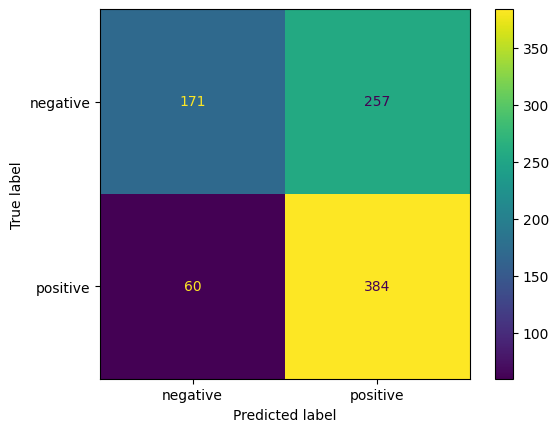

In [61]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])
disp.plot()
plt.show()

0.6321987875726194


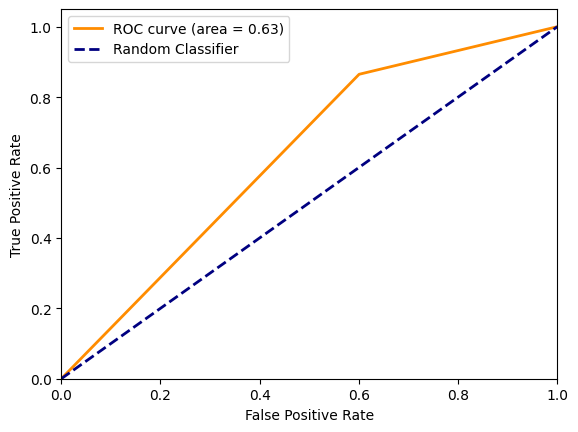

In [62]:
tpr, fpr, _ = roc_curve(labels, preds)
roc_auc = auc(tpr, fpr)
print(roc_auc)
plt.figure()
plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()

Text(0, 0.5, 'Accuracy (%)')

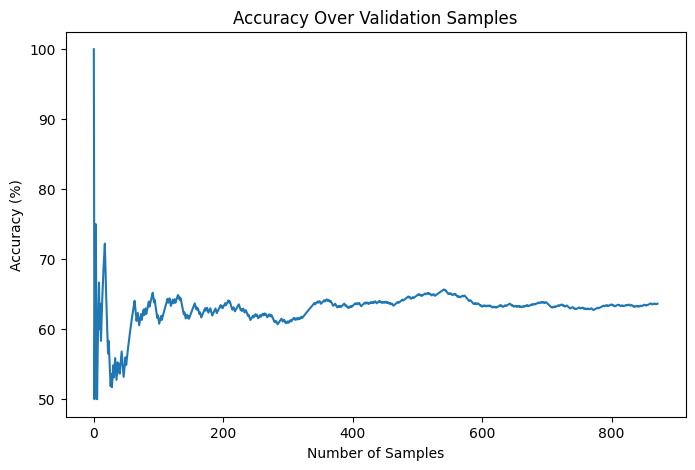

In [63]:
accuracies = np.cumsum(np.array(all_labels) == np.array(all_preds)) / np.arange(1, len(all_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Validation Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")

Both models perform similarly, but they both bias different classes. Including two negative examples in the prompt could introduce bias for the negative sentiment class.